In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('expand_frame_repr', False)

In [3]:
def lag_features(df, lags=5):
    for lag in range(1, lags + 1):
        df[f'VOI{lag}'] = df['VOI'].shift(lag)
        df[f'OIR{lag}'] = df['OIR'].shift(lag)
    return df

In [21]:
# Load and Prepare Data
book_paths = [
    "C:/Users/trgrd/OneDrive/Trading/Projects/data_download/data/ETH/ETH_book_20240418.pkl",
    "C:/Users/trgrd/OneDrive/Trading/Projects/data_download/data/ETH/ETH_book_20240419.pkl"
]
book_list = [pd.DataFrame(pd.read_pickle(path)) for path in book_paths]
book = pd.concat(book_list, ignore_index=True)

# Get the best bids and asks
Pb = np.array([float(book['levels'][i][0][0]['price']) for i in range(len(book))])
Pa = np.array([float(book['levels'][i][1][0]['price']) for i in range(len(book))])

# Get the corresponding volumes
Qb = np.array([float(book['levels'][i][0][0]['size']) for i in range(len(book))])
Qa = np.array([float(book['levels'][i][1][0]['size']) for i in range(len(book))])

# Calculate the mid-price
mid = (Pa + Pb) / 2
book_time = pd.to_datetime(book['timestamp'], unit='ms')

# Calculate order book imalance
I = np.where(Qb + Qa != 0, Qb / (Qb + Qa), 0)

# Create a DataFrame including these
df = pd.DataFrame({
    'time': book_time,
    'mid': mid,
    'I': I,
    'Qb': Qb,
    'Qa': Qa,
    'Pa': Pa,
    'Pb': Pb
})
df.set_index('time', inplace=True)

In [67]:
# Define time shift for prediction
h = 30 # in multiples of 100ms. 30 => 30 * 100ms = 3 seconds

# Calculate future midprice based on time shift
df['mid_future'] = df['mid'].shift(-h)
df.dropna(inplace=True)

# Create Dependent Variable Continuous Price Change
df['price_change'] = df['mid_future'] - df['mid']

# Compute Order imbalance ratio
df['OIR'] = np.where((df['Qb'] + df['Qa']) != 0, (df['Qb'] - df['Qa']) / (df['Qb'] + df['Qa']), 0)

# Compute volume order imbalance
df['delta_Qb'] = df['Qb'].diff(1).fillna(0)
df['delta_Qa'] = df['Qa'].diff(1).fillna(0)
df['spread'] = df['Pa'] - df['Pb']
df['VOI'] = (df['delta_Qb'] - df['delta_Qa'])
df['VOI_normalized'] = np.where(df['spread'] != 0, df['VOI'] / df['spread'], 0)

# Create lagged features for VOI and OIR
df_lagged = lag_features(df.copy(), lags=5).sort_index()

# Define Feature Columns
feature_columns = [
    'VOI', 'OIR', 'spread',
    # 'VOI1', 'VOI2', 'VOI3',
    'VOI4', 'VOI5'
    # 'OIR1', 'OIR2', 'OIR3', 'OIR4', 'OIR5'
]

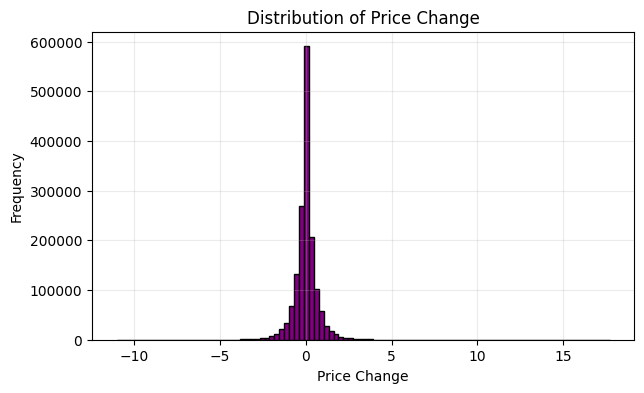

Correlation Matrix
                   VOI       OIR    spread      VOI4      VOI5  price_change
VOI           1.000000  0.121297  0.001885 -0.010228 -0.071171      0.033800
OIR           0.121297  1.000000  0.051427  0.119034  0.102175      0.305121
spread        0.001885  0.051427  1.000000  0.002188  0.003324      0.034149
VOI4         -0.010228  0.119034  0.002188  1.000000 -0.000004      0.035058
VOI5         -0.071171  0.102175  0.003324 -0.000004  1.000000      0.033209
price_change  0.033800  0.305121  0.034149  0.035058  0.033209      1.000000


In [68]:
# Plot the target distribution and the correlation matrix
plt.figure(figsize=(7, 4))
plt.hist(df_lagged['price_change'], bins=100, color='purple', edgecolor='black')
plt.title('Distribution of Price Change')
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.grid(alpha=0.25)
plt.show()

# Correlation matrix
corr_matrix = df_lagged[feature_columns + ['price_change']].corr()
print(f"Correlation Matrix\n{corr_matrix}")

In [69]:
# Prepare the regression model
y = df_lagged['price_change']   # Target
X = df_lagged[feature_columns]  # Predictors

# Drop the NaN rows
y = y[5:]
X = X[5:]

# Add constant for intercept
X = sm.add_constant(X)

# Split data into train and test
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train sample size: {len(X_train)}\nTest sample size: {len(X_test)}")

Train sample size: 1270123
Test sample size: 317531


                            OLS Regression Results                            
Dep. Variable:           price_change   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                 2.612e+04
Date:                Fri, 08 Nov 2024   Prob (F-statistic):               0.00
Time:                        09:38:16   Log-Likelihood:            -1.2541e+06
No. Observations:             1270123   AIC:                         2.508e+06
Df Residuals:                 1270117   BIC:                         2.508e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0161      0.001    -17.116      0.0

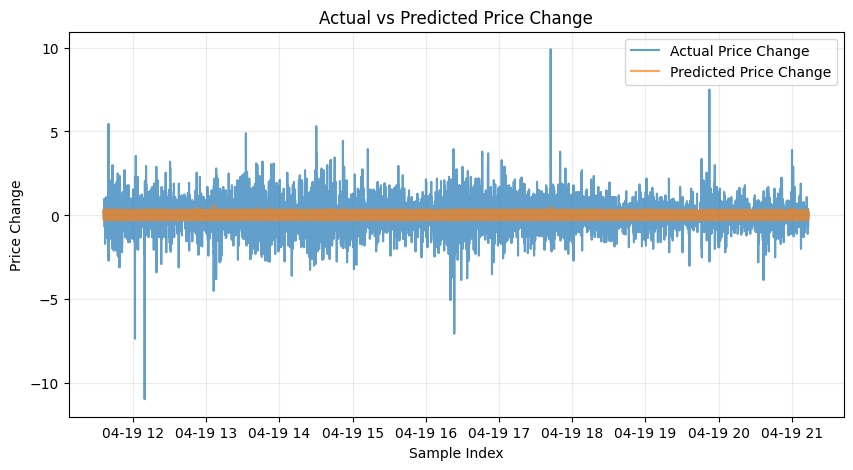

In [70]:
# Do linear regression
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE = {mse:.4f}\nR-squared = {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label='Actual Price Change', alpha=0.7)
plt.plot(y_pred.index, y_pred.values, label='Predicted Price Change', alpha=0.7)
plt.title('Actual vs Predicted Price Change')
plt.xlabel('Sample Index')
plt.ylabel('Price Change')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

In [ ]:
# Correlation between actual and predicted
corr = np.corrcoef(y_test, y_pred)[0, 1]
print(f"Correlation between actual and predicted price change: {corr:.4f}")

Correlation between actual and predicted price Change: 0.2992


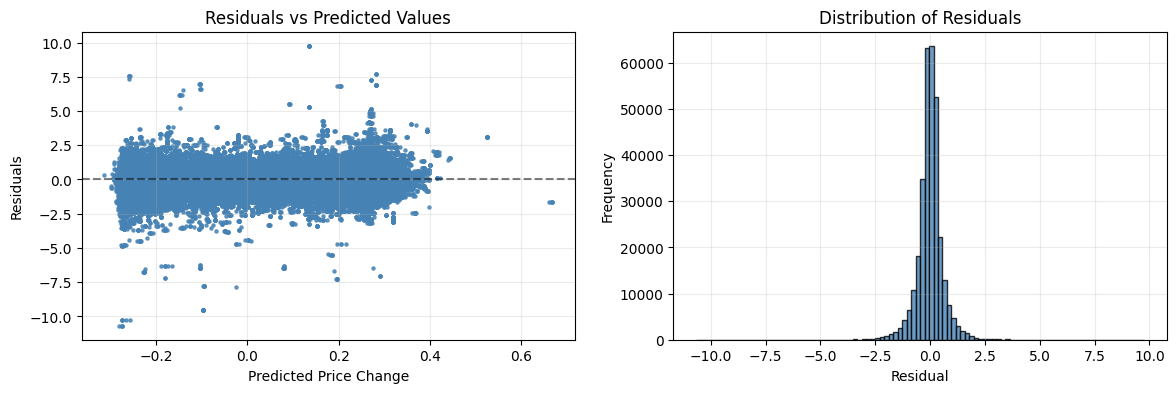

In [ ]:
# Inspect the residuals to confirm assumptions
residuals = y_test - y_pred

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].scatter(x=y_pred, y=residuals, alpha=0.8, s=5, color='steelblue')
ax[0].axhline(0, color='black', alpha=0.5, ls='--')
ax[0].set_title('Residuals vs Predicted Values')
ax[0].set_xlabel('Predicted Price Change')
ax[0].set_ylabel('Residuals')
ax[0].grid(alpha=0.25)

ax[1].hist(residuals, bins=100, color='steelblue', alpha=0.8, edgecolor='black')
ax[1].set_title('Distribution of Residuals')
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Frequency')
ax[1].grid(alpha=0.25)

plt.show()